# Dataset E Coli

## Übersicht

- Generieren von Datensatz für E Coli
- Outlier finden

## Imports

In [1]:
import os
import sys
import shutil

sys.path.append('../src')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import Rank1D, Rank2D

import pandas as pd
import numpy as np
import seaborn as sns

from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature
from features.pssm import calculate_pssm_feature
from features.coexp import calculate_coexp_feature
from models.eval import nested_crossval
from visualization.feature_plots import create_plot

## Globals

In [2]:
LOG_FILE = "../logs/ecoli_amino_sugar.log"
N_THREADS = 12

## Functions

In [3]:
def get_label_colors(labels):
    labels_unique = np.unique(labels)
    colors = ["red", "green", "blue", "yellow", "magenta", "cyan"]
    colors_dict = {labels_unique[i]: colors[i] for i in range(len(labels_unique))}
    colors_labels = [colors_dict[label] for label in labels]
    return colors_labels, colors_dict

def feature_corr_plot(df_features, df_labels):
    sns.set(font_scale=0.8)
    sns.clustermap(
        data=df_features.corr(),
        xticklabels=df_features.columns,
        yticklabels=df_features.columns,
        method="ward",
    )
    sns.set(font_scale=1)

def sample_corr_plot(df_features, df_labels, label_colors):
    sns.set(font_scale=0.5)
    sns.clustermap(
        data=df_features.transpose().corr(),
        xticklabels=df_labels.index,
        yticklabels=df_labels.index,
        col_colors=label_colors,
        row_colors=label_colors,
        method="ward",
    )
    sns.set(font_scale=1)

def get_independent_test_set(
    df_features, df_labels_, pos_label, test_size=0.2, random_state=1
):
    X = df_features.to_numpy()
    y = np.where(df_labels_.labels == pos_label, 1, 0)
    feature_names = df_features.columns.to_numpy()
    sample_names = df_features.index.to_numpy()
    (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
    ) = train_test_split(
        X, y, sample_names, stratify=y, random_state=random_state, shuffle=True, test_size=test_size
    )
    return (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
        feature_names,
    )

## 1. Analyzing the dataset

### Filtering (Keywords, Organismus)

First, creating the dataset with only minimal filtering. Multi-substrate transporters are kept in the dataset.

In [4]:
# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, 'w'):
        pass

create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Membrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    verbose = True,
    tax_ids_filter = [83333],
    output_tsv = "../data/datasets/ecoli_amino_sugar.tsv",
    output_fasta = "../data/datasets/ecoli_amino_sugar.fasta",
    output_log = LOG_FILE,
)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0AAG8,Sugar transport,Cell inner membrane;Cell membrane;Membrane,Transport,mglA b2149 JW2136,Galactose/methyl galactoside import ATP-bindin...,3.A.1.2.3,83333,MVSSTTPSSGEYLLEMSGINKSFPGVKALDNVNLKVRPHSIHALMG...
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...
P36672,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,treB b4240 JW4199,PTS system trehalose-specific EIIBC component ...,4.A.1.2.4,83333,MMSKINQTDIDRLIELVGGRGNIATVSHCITRLRFVLNQPANARPK...
P56580,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,srlE gutA gutE b2703 JW5430,PTS system glucitol/sorbitol-specific EIIB com...,4.A.4.1.1,83333,MTHIRIEKGTGGWGGPLELKATPGKKIVYITAGTRPAIVDKLAQLT...
P04983,Sugar transport,Cell inner membrane;Cell membrane;Membrane,Transport,rbsA b3749 JW3728,Ribose import ATP-binding protein RbsA (EC 7.5...,3.A.1.2.1,83333,MEALLQLKGIDKAFPGVKALSGAALNVYPGRVMALVGENGAGKSTM...
...,...,...,...,...,...,...,...,...
P19642,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,malX b1621 JW1613,PTS system maltose-specific EIICB component [I...,4.A.1.1.3,83333,MTAKTAPKVTLWEFFQQLGKTFMLPVALLSFCGIMLGIGSSLSSHD...
P0AAD4,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,tyrP b1907 JW1895,Tyrosine-specific transport protein (Tyrosine ...,2.A.42.1.1,83333,MKNRTLGSVFIVAGTTIGAGMLAMPLAAAGVGFSVTLILLIGLWAL...
P23173,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,tnaB trpP b3709 JW5619/JW5622,Low affinity tryptophan permease,2.A.42.1.3,83333,MTDQAEKKHSAFWGVMVIAGTVIGGGMFALPVDLAGAWFFWGAFIL...


### Creating a table of GO/Keyword annotations

TODO: Wenn nötig dann Keywords und GO terms zu Tabelle hinzufügen

In [5]:
df_annotations = pd.read_table("../data/datasets/ecoli_amino_sugar.tsv", index_col=0)
df_annotations.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0AAG8,Sugar transport,Cell inner membrane;Cell membrane;Membrane,Transport,mglA b2149 JW2136,Galactose/methyl galactoside import ATP-bindin...,3.A.1.2.3,83333,MVSSTTPSSGEYLLEMSGINKSFPGVKALDNVNLKVRPHSIHALMG...
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...
P36672,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,treB b4240 JW4199,PTS system trehalose-specific EIIBC component ...,4.A.1.2.4,83333,MMSKINQTDIDRLIELVGGRGNIATVSHCITRLRFVLNQPANARPK...
P56580,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,srlE gutA gutE b2703 JW5430,PTS system glucitol/sorbitol-specific EIIB com...,4.A.4.1.1,83333,MTHIRIEKGTGGWGGPLELKATPGKKIVYITAGTRPAIVDKLAQLT...
P04983,Sugar transport,Cell inner membrane;Cell membrane;Membrane,Transport,rbsA b3749 JW3728,Ribose import ATP-binding protein RbsA (EC 7.5...,3.A.1.2.1,83333,MEALLQLKGIDKAFPGVKALSGAALNVYPGRVMALVGENGAGKSTM...


### Substrate 

Es gibt insgesamt 8 Proteine mit mehreren Substrate im Datensatz. 

In [6]:
df_annotations.keywords_transport.value_counts()

Amino-acid transport                                      57
Sugar transport                                           55
Ion transport;Sugar transport                              4
Amino-acid transport;Ion transport;Sodium transport        2
Ion transport;Polysaccharide transport;Sugar transport     1
Phosphate transport;Sugar transport                        1
Name: keywords_transport, dtype: int64

### Annotationen der Multi-substrat Proteine.

- Kategorie 1: Zucker-Porine aus TCDB Klasse 1, die sich laut Uniprot-Einträgen in der äußeren Membran befinden. 
    - Scheinbar sind nur Proteine in der inneren Membran mit "Cell Membrane" annotiert, Proteine in der äußeren nur mit "Membrane"
    - Es wäre also wahrscheinlich besser, nach "Cell membrane" zu filtern anstatt nach "Membrane". 
- Kategorie 2: zwei Amino-säure Symporter in der inneren Membran
- Kategorie 3: Ein Zucker/Phosphat Antiporter in der inneren Membran

In [7]:
df_annotations[df_annotations.keywords_transport.str.contains(";")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P76773,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,ompL yshA b3875 JW3846,Porin OmpL,1.B.35.2.2,83333,MKKINAIILLSSLTSASVFAGAYVENREAYNLASDQGEVMLRVGYN...
P07117,Amino-acid transport;Ion transport;Sodium tran...,Cell inner membrane;Cell membrane;Membrane;Tra...,Symport;Transport,putP b1015 JW1001,Sodium/proline symporter (Proline permease) (P...,2.A.21.2.1,83333,MAISTPMLVTFCVYIFGMILIGFIAWRSTKNFDDYILGGRSLGPFV...
Q47706,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,uidC gusC b1615 JW1607,Membrane-associated protein UidC,1.B.25.1.5,83333,MRKIVAMAVICLTAASGLTSAYAAQLADDEAGLRIRLKNELRRADK...
P02943,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,lamB malB b4036 JW3996,Maltoporin (Maltose outer membrane channel) (M...,1.B.3.1.1,83333,MMITLRKLPLAVAVAAGVMSAQAMAVDFHGYARSGIGWTGSGGEQQ...
P75733,Ion transport;Polysaccharide transport;Sugar t...,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,chiP ybfM b0681 JW0667,Chitoporin (ChiP-III),1.B.25.1.13,83333,MRTFSGKRSTLALAIAGVTAMSGFMAMPEARAEGFIDDSTLTGGIY...
P0AER8,Amino-acid transport;Ion transport;Sodium tran...,Cell inner membrane;Cell membrane;Membrane;Tra...,Symport;Transport,gltS gltC b3653 JW3628,Sodium/glutamate symporter (Glutamate permease),2.A.27.1.1,83333,MFHLDTLATLVAATLTLLLGRKLVHSVSFLKKYTIPEPVAGGLLVA...
P69856,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,nanC yjhA b4311 JW5778,Probable N-acetylneuraminic acid outer membran...,1.B.35.2.1,83333,MKKAKILSGVLLLCFSSPLISQAATLDVRGGYRSGSHAYETRLKVS...
P0AGC0,Phosphate transport;Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,uhpT b3666 JW3641,Hexose-6-phosphate:phosphate antiporter,2.A.1.4.1,83333,MLAFLNQVRKPTLDLPLEVRRKMWFKPFMQSYLVVFIGYLTMYLIR...


### Verteilung der Locations

- Die Proteine in der Kategorie "Membrane;Transmembrane" befinden sich in der äußeren Membran. Da es davon nur 5 gibt, und diese sich stark vom Rest des Datensatz unterscheiden, wäre es gut diese 5 auszuschließen. 
- Es gibt 15 Proteine ohne das Keyword Transmembrane, handelt es sich dabei um Periphäre Proteine oder fehlt nur die Annotation?

In [8]:
df_annotations.keywords_location.value_counts()

Cell inner membrane;Cell membrane;Membrane;Transmembrane    99
Cell inner membrane;Cell membrane;Membrane                  14
Cell outer membrane;Membrane;Transmembrane                   5
Cell membrane;Membrane                                       1
Cell membrane;Membrane;Transmembrane                         1
Name: keywords_location, dtype: int64

### Sind alle Proteine ohne das Keyword "Transmembrane" keine Transmembranproteine?

- 5 Stichproben waren alle periphäre Proteine
- TODO: "Peripheral membrane protein" als Spalte zu Datensatz hinzufügen
    - Geht nicht so einfach, da es sich um eine "Subcellular-location" handelt, was eine andere hierarchie ist als die Keywords
    - Zusätzliche tsv Datei wäre einfacher
- Transmembrane schließt PMP aus, also nehme ich das erstmal als Filter.

In [9]:
df_annotations[~df_annotations.keywords_location.str.contains("Transmembrane")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0AAG8,Sugar transport,Cell inner membrane;Cell membrane;Membrane,Transport,mglA b2149 JW2136,Galactose/methyl galactoside import ATP-bindin...,3.A.1.2.3,83333,MVSSTTPSSGEYLLEMSGINKSFPGVKALDNVNLKVRPHSIHALMG...
P04983,Sugar transport,Cell inner membrane;Cell membrane;Membrane,Transport,rbsA b3749 JW3728,Ribose import ATP-binding protein RbsA (EC 7.5...,3.A.1.2.1,83333,MEALLQLKGIDKAFPGVKALSGAALNVYPGRVMALVGENGAGKSTM...
P10346,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane,Transport,glnQ b0809 JW0794,Glutamine transport ATP-binding protein GlnQ,3.A.1.3.2,83333,MIEFKNVSKHFGPTQVLHNIDLNIAQGEVVVIIGPSGSGKSTLLRC...
P28635,Amino-acid transport,Cell membrane;Membrane,Transport,metQ yaeC b0197 JW0193,D-methionine-binding lipoprotein MetQ,3.A.1.24.1,83333,MAFKFKTFAAVGALIGSLALVGCGQDEKDPNHIKVGVIVGAEQQVA...
P14175,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane,Transport,proV b2677 JW2652,Glycine betaine/proline betaine transport syst...,3.A.1.12.1,83333,MAIKLEIKNLYKIFGEHPQRAFKYIEQGLSKEQILEKTGLSLGVKD...
P69797,Sugar transport,Cell inner membrane;Cell membrane;Membrane,Transport,manX gptB ptsL b1817 JW1806,PTS system mannose-specific EIIAB component (E...,4.A.6.1.1,83333,MTIAIVIGTHGWAAEQLLKTAEMLLGEQENVGWIDFVPGENAETLI...
P37388,Sugar transport,Cell inner membrane;Cell membrane;Membrane,Transport,xylG b3567 JW3539,Xylose import ATP-binding protein XylG (EC 7.5...,3.A.1.2.4,83333,MPYLLEMKNITKTFGSVKAIDNVCLRLNAGEIVSLCGENGSGKSTL...
P30750,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane,Transport,metN abc b0199 JW0195,Methionine import ATP-binding protein MetN (EC...,3.A.1.24.1,83333,MIKLSNITKVFHQGTRTIQALNNVSLHVPAGQIYGVIGASGAGKST...
P10907,Sugar transport,Cell inner membrane;Cell membrane;Membrane,Transport,ugpC b3450 JW3415,sn-glycerol-3-phosphate import ATP-binding pro...,3.A.1.1.3,83333,MAGLKLQAVTKSWDGKTQVIKPLTLDVADGEFIVMVGPSGCGKSTL...


### Clustermap der AAC korrelation, annotiert mit Substraten

- Es sind klar zwei Cluster zu erkennen. 
- Das kleinere Cluster hat ein noch weiter entferntes Cluster, das sind die multi-substrat transporter aus TCDB Klasse 1
- Die Multi-substrat transporter aus TCDB Klasse 2 scheinen gut in den rest des Datensatzens zu passen, die könnte ich evtl drin lassen?

                                                      Color
Amino-acid transport                                    red
Amino-acid transport;Ion transport;Sodium trans...    green
Ion transport;Polysaccharide transport;Sugar tr...     blue
Ion transport;Sugar transport                        yellow
Phosphate transport;Sugar transport                 magenta
Sugar transport                                        cyan


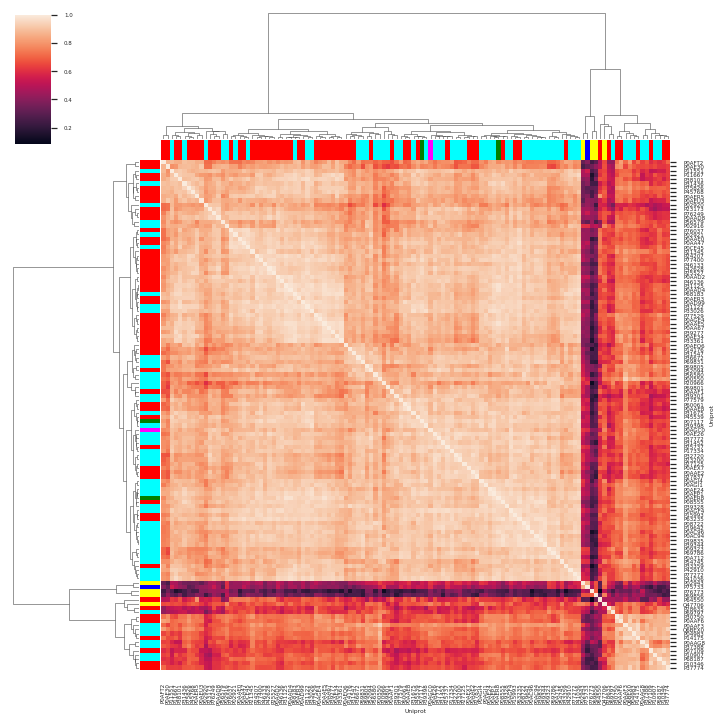

In [10]:
fasta_to_labels(
    input_fasta="../data/datasets/ecoli_amino_sugar.fasta",
    output_tsv="../data/features/ecoli_amino_sugar_labels.tsv"
)
calculate_composition_feature(
    input_fasta="../data/datasets/ecoli_amino_sugar.fasta",
    output_tsv=f"../data/features/ecoli_amino_sugar_aac.tsv",
    feature_type="aac",
)

df_aac = pd.read_table(f"../data/features/ecoli_amino_sugar_aac.tsv", index_col=0)
df_labels = pd.read_table("../data/features/ecoli_amino_sugar_labels.tsv", index_col=0)
label_colors, label_dict = get_label_colors(df_labels.labels)
print(pd.DataFrame.from_dict(label_dict, orient="index", columns=["Color"]))
sample_corr_plot(df_aac, df_labels, label_colors)

### Clustermap mit Locations

- Die Clustermap mit den Locations einzufärben macht das noch klarer.
- Es gibt drei cluster:
    - Innere membran + transmembrane keyword
    - Kein transmembrane keyword (also periphäres, transport-related protein)
    - Äußere membran

                                                      Color
Cell inner membrane;Cell membrane;Membrane              red
Cell inner membrane;Cell membrane;Membrane;Tran...    green
Cell membrane;Membrane                                 blue
Cell membrane;Membrane;Transmembrane                 yellow
Cell outer membrane;Membrane;Transmembrane          magenta


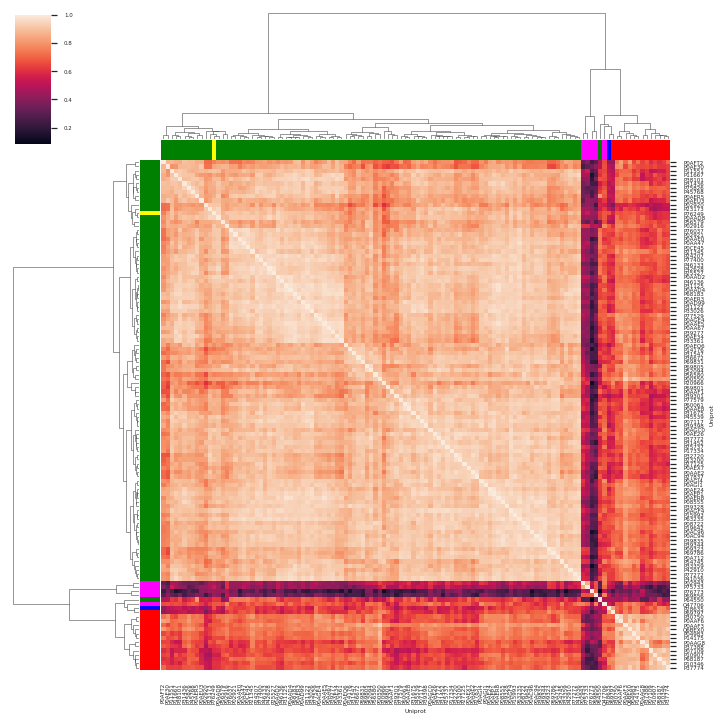

In [11]:
fasta_to_labels(
    input_fasta="../data/datasets/ecoli_amino_sugar.fasta",
    output_tsv="../data/features/ecoli_amino_sugar_labels.tsv"
)
calculate_composition_feature(
    input_fasta="../data/datasets/ecoli_amino_sugar.fasta",
    output_tsv=f"../data/features/ecoli_amino_sugar_aac.tsv",
    feature_type="aac",
)

df_aac = pd.read_table(f"../data/features/ecoli_amino_sugar_aac.tsv", index_col=0)
df_labels = pd.read_table("../data/features/ecoli_amino_sugar_labels.tsv", index_col=0)
label_colors, label_dict = get_label_colors(df_annotations.keywords_location)

print(pd.DataFrame.from_dict(label_dict, orient="index", columns=["Color"]))

sample_corr_plot(df_aac, df_labels, label_colors)

### Generieren der Outlier-Liste

- Outer membrane
- Not transmembrane

In [12]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=2, linkage="ward", compute_distances=True)
ward.fit(df_aac.T.corr())
print("Cluster sizes", np.unique(ward.labels_, return_counts=True)[1])

proteins_cluster0 = df_aac.index[ward.labels_ == 0]
proteins_cluster1 = df_aac.index[ward.labels_ == 1]

# cluster 0 ist das kleinere
outliers = proteins_cluster0
outliers.tolist()

Cluster sizes [21 99]


['P0AAG8',
 'P04983',
 'P10346',
 'P28635',
 'P14175',
 'P69797',
 'P76773',
 'P37388',
 'P30750',
 'Q47706',
 'P10907',
 'P37774',
 'P0AAF3',
 'P64550',
 'P02943',
 'P75733',
 'P0AAF6',
 'P68187',
 'P69856',
 'P07109',
 'Q6BEX0']

In [13]:
df_annotations.loc[outliers]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P0AAG8,Sugar transport,Cell inner membrane;Cell membrane;Membrane,Transport,mglA b2149 JW2136,Galactose/methyl galactoside import ATP-bindin...,3.A.1.2.3,83333,MVSSTTPSSGEYLLEMSGINKSFPGVKALDNVNLKVRPHSIHALMG...
P04983,Sugar transport,Cell inner membrane;Cell membrane;Membrane,Transport,rbsA b3749 JW3728,Ribose import ATP-binding protein RbsA (EC 7.5...,3.A.1.2.1,83333,MEALLQLKGIDKAFPGVKALSGAALNVYPGRVMALVGENGAGKSTM...
P10346,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane,Transport,glnQ b0809 JW0794,Glutamine transport ATP-binding protein GlnQ,3.A.1.3.2,83333,MIEFKNVSKHFGPTQVLHNIDLNIAQGEVVVIIGPSGSGKSTLLRC...
P28635,Amino-acid transport,Cell membrane;Membrane,Transport,metQ yaeC b0197 JW0193,D-methionine-binding lipoprotein MetQ,3.A.1.24.1,83333,MAFKFKTFAAVGALIGSLALVGCGQDEKDPNHIKVGVIVGAEQQVA...
P14175,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane,Transport,proV b2677 JW2652,Glycine betaine/proline betaine transport syst...,3.A.1.12.1,83333,MAIKLEIKNLYKIFGEHPQRAFKYIEQGLSKEQILEKTGLSLGVKD...
P69797,Sugar transport,Cell inner membrane;Cell membrane;Membrane,Transport,manX gptB ptsL b1817 JW1806,PTS system mannose-specific EIIAB component (E...,4.A.6.1.1,83333,MTIAIVIGTHGWAAEQLLKTAEMLLGEQENVGWIDFVPGENAETLI...
P76773,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,ompL yshA b3875 JW3846,Porin OmpL,1.B.35.2.2,83333,MKKINAIILLSSLTSASVFAGAYVENREAYNLASDQGEVMLRVGYN...
P37388,Sugar transport,Cell inner membrane;Cell membrane;Membrane,Transport,xylG b3567 JW3539,Xylose import ATP-binding protein XylG (EC 7.5...,3.A.1.2.4,83333,MPYLLEMKNITKTFGSVKAIDNVCLRLNAGEIVSLCGENGSGKSTL...
P30750,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane,Transport,metN abc b0199 JW0195,Methionine import ATP-binding protein MetN (EC...,3.A.1.24.1,83333,MIKLSNITKVFHQGTRTIQALNNVSLHVPAGQIYGVIGASGAGKST...


## 2. Datensatz ohne die Outlier 

Ich lasse erstmal die drei Zucker bzw. Aminosäure Symporter aus Klasse 2A im Datensatz.

In [14]:
# Save datasets with outliers for later.
df_aac_outliers = df_aac.copy()
df_labels_outliers = df_labels.copy()
df_annotations_outliers = df_annotations.copy()

In [15]:
# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, "w"):
        pass

create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Membrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    verbose=True,
    outliers=outliers.tolist(),
    tax_ids_filter=[83333],
    output_tsv="../data/datasets/ecoli_amino_sugar.tsv",
    output_fasta="../data/datasets/ecoli_amino_sugar.fasta",
    output_log=LOG_FILE,
)

fasta_to_labels(
    input_fasta="../data/datasets/ecoli_amino_sugar.fasta",
    output_tsv="../data/features/ecoli_amino_sugar_labels.tsv",
)
calculate_composition_feature(
    input_fasta="../data/datasets/ecoli_amino_sugar.fasta",
    output_tsv=f"../data/features/ecoli_amino_sugar_aac.tsv",
    feature_type="aac",
)
df_aac = pd.read_table("../data/features/ecoli_amino_sugar_aac.tsv", index_col=0)
df_labels = pd.read_table("../data/features/ecoli_amino_sugar_labels.tsv", index_col=0)
df_labels.labels.value_counts()
df_annotations = pd.read_table("../data/datasets/ecoli_amino_sugar.tsv", index_col=0)

## 3. Feature visualization (AAC, Clustering 100, Without outliers)

### 3.1 Clustermap

- Der Datensatz lässt sich grob in ein Zucker- und Aminosäure Cluster einteilen. 
- Mit mehreren Dimensionen könnten die Ergebnisse besser werden. 

{'Amino-acid transport': 'red', 'Sugar transport': 'green'}


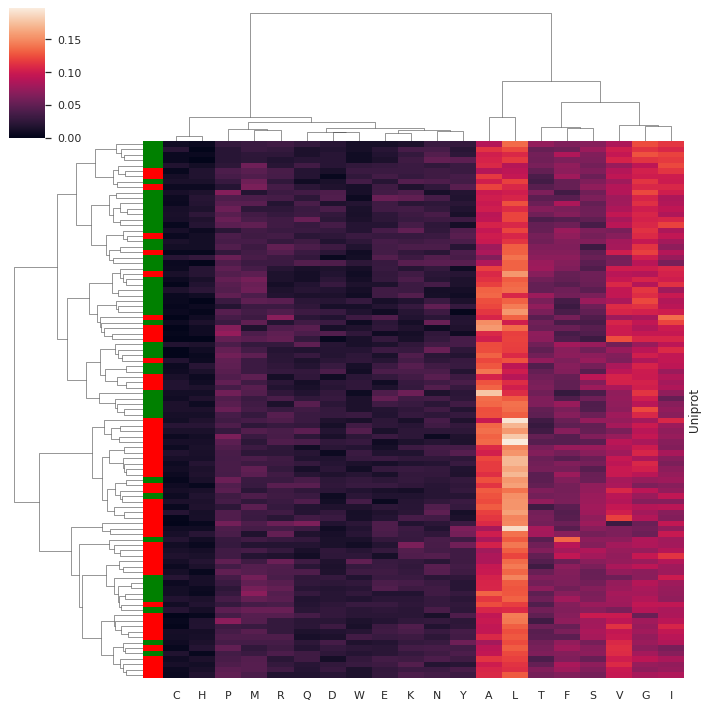

In [16]:
label_colors, label_dict = get_label_colors(df_labels.labels)
sns.clustermap(
    data=df_aac,
    row_colors=label_colors,
    yticklabels=[],
    method="ward",
)
sns.set(font_scale=1)
print(label_dict)

### TCDB IDs in Datensatz

- In TCDB Klasse 4 gibt es nur Zucker-Transporter, alle sind im oberen cluster.

     sum  sugar  amino   color
2.A   55     19   36.0     red
3.A   23      9   14.0   green
4.A   17     17    NaN    blue
Nan    4      3    1.0  yellow


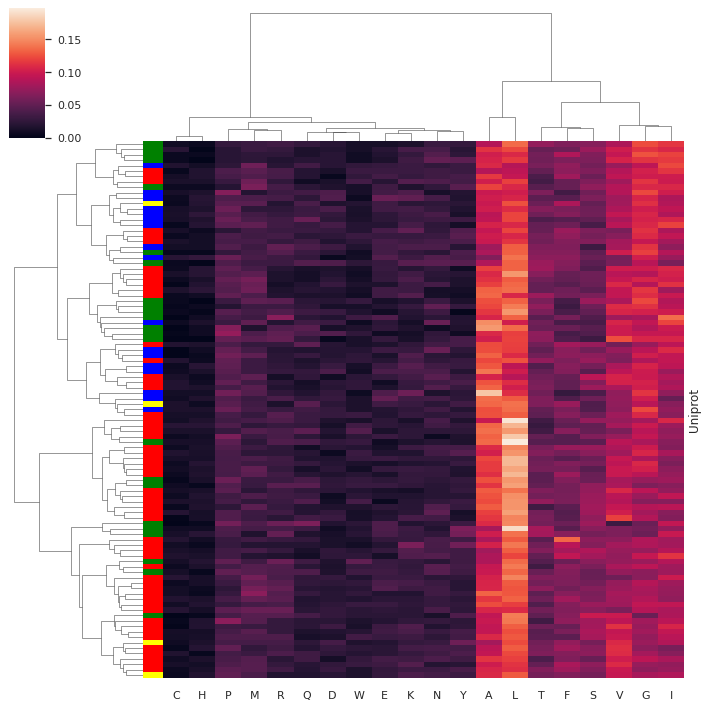

In [17]:
tcdb_labels = df_annotations.fillna("Nan").tcdb_id.apply(lambda s: s[0:3])
tcdb_labels_sugar = (
    df_annotations[df_annotations.keywords_transport == "Sugar transport"]
    .fillna("Nan")
    .tcdb_id.apply(lambda s: s[0:3])
)
tcdb_labels_amino = (
    df_annotations[df_annotations.keywords_transport == "Amino-acid transport"]
    .fillna("Nan")
    .tcdb_id.apply(lambda s: s[0:3])
)

label_colors, colors_dict = get_label_colors(tcdb_labels)

df_tcdb_stats = pd.concat(
    [
        tcdb_labels.value_counts(),
        tcdb_labels_sugar.value_counts(),
        tcdb_labels_amino.value_counts(),
        pd.DataFrame.from_dict(colors_dict, orient="index", columns=["Color"]),
    ],
    axis=1,
)
df_tcdb_stats.columns = ["sum", "sugar","amino", "color"]
print(df_tcdb_stats)


sns.clustermap(
    data=df_aac,
    # xticklabels=df_labels.index,
    yticklabels=[],
    # col_colors=label_colors,
    row_colors=label_colors,
    method="ward",
)


### 3.3 Korrelation der Features

Keine starke Korrelation zwischen zwei Features

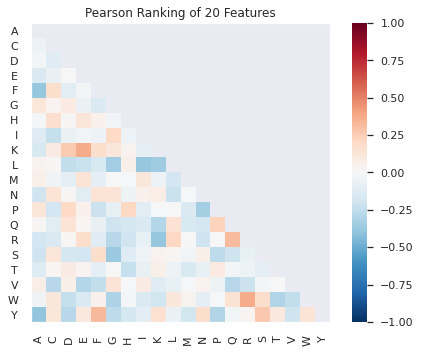

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [18]:
r2d = Rank2D(algorithm="pearson")
r2d.fit_transform(df_aac, df_labels.labels)
r2d.show()

#### Nur AA transporter

Starke korrelation zwischen K/F und R/Q

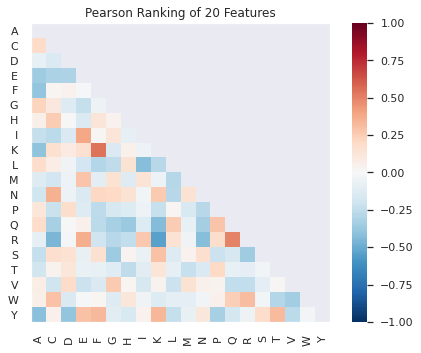

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [19]:
mask_amino = df_labels.labels == "Amino-acid transport"
r2d = Rank2D(algorithm='pearson')
r2d.fit_transform(df_aac.loc[mask_amino], df_labels.loc[mask_amino].labels)
r2d.show()

#### Nur Sugar transporter

Korrelation K/E und P/H

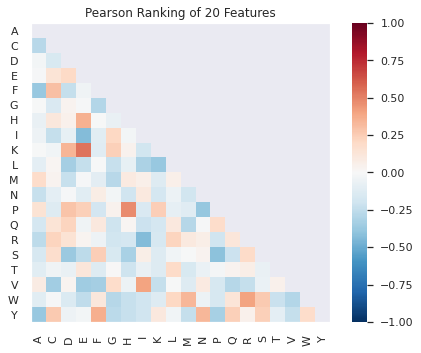

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [20]:
mask_sugar = df_labels.labels == "Sugar transport"
r2d = Rank2D(algorithm='pearson')
r2d.fit_transform(df_aac.loc[mask_sugar], df_labels.loc[mask_sugar].labels)
r2d.show()

### 3.4 Folgen die AAC Features einer Normalverteilung?

Bei den Verteilungen von F und Q scheint es evtl wenige Outlier zu geben.

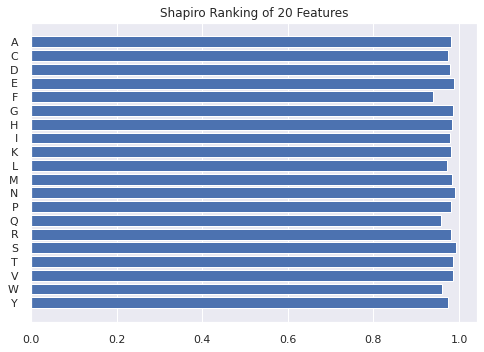

<AxesSubplot:title={'center':'Shapiro Ranking of 20 Features'}>

In [21]:
r2d = Rank1D(algorithm="shapiro")
r2d.fit_transform(df_aac, df_labels.labels)
r2d.show()

#### Verteilungen F und Q

Die drei Proteine mit ungewöhnlichen AAC scores haben keine besonderen Auffälligkeiten. 

- P02920 ist zwar annotiert als "Symport", hat aber keine zwei Substrate im Datensatz. Laut Uniprot ist er ein Kohlenwasserstoff/Proton Symporter.

In [22]:
def filter_amino_acids(AA:str, gt):
    return (
        df_annotations.loc[df_aac[df_aac[AA] > gt].index]
        .join(df_aac[AA], how="left")
        .drop("sequence", axis=1).
        sort_values(AA, ascending=False)
    )

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,F
Uniprot,,,,,,,,
P02920,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Symport;Transport,lacY b0343 JW0334,Lactose permease (Lactose-proton symport),2.A.1.5.1,83333,0.134293


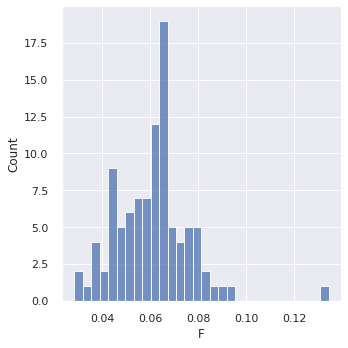

In [23]:
sns.displot(df_aac.F, bins=30)
filter_amino_acids("F", 0.10)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,Q
Uniprot,,,,,,,,
P0AFT2,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,tcyL yecS b1918 JW1903,L-cystine transport system permease protein TcyL,3.A.1.3.10,83333,0.063063
P36672,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,treB b4240 JW4199,PTS system trehalose-specific EIIBC component ...,4.A.1.2.4,83333,0.052854


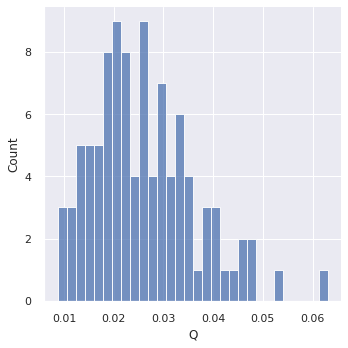

In [24]:
sns.displot(df_aac.Q, bins=30)
filter_amino_acids("Q", 0.05)

### 3.5 Feature importance

Hier geht es darum, die Wichtigkeit der Features für die Klassifikation festzustellen. 

Der Glycin-Anteil scheint sehr wichtig zu sein.

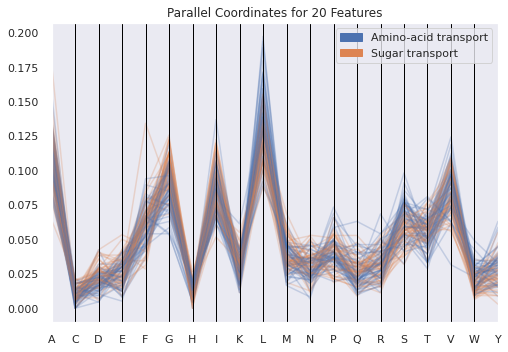

<AxesSubplot:>

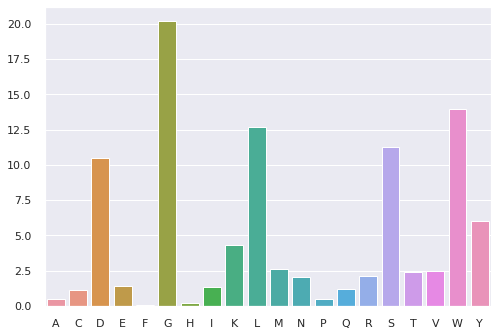

In [25]:
pc = ParallelCoordinates()

pc.fit_transform(df_aac, df_labels.labels)
pc.show()

skb = SelectKBest(k=20)
skb.fit(df_aac, df_labels.labels)
sns.barplot(x=df_aac.columns, y=skb.scores_)


### 3.6 Boxplots alle, amino, sugar

<AxesSubplot:>

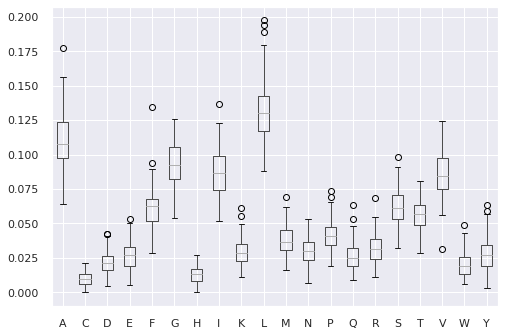

In [26]:
df_aac.boxplot()

<AxesSubplot:>

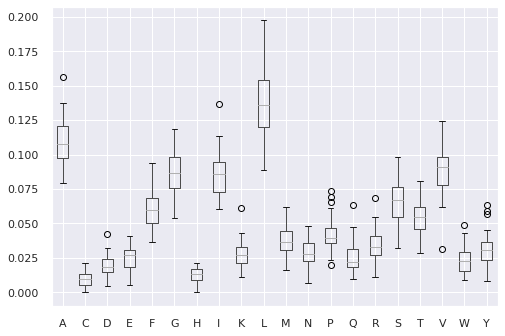

In [27]:
df_aac.loc[df_labels.labels == "Amino-acid transport"].boxplot()

<AxesSubplot:>

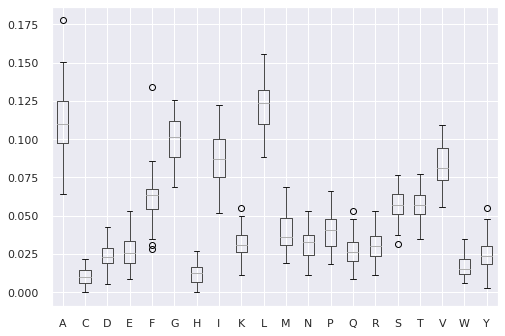

In [28]:
df_aac.loc[df_labels.labels == "Sugar transport"].boxplot()

### PCA Plots

Zwei unterscheidbare Mengen mit größerer Überlappung

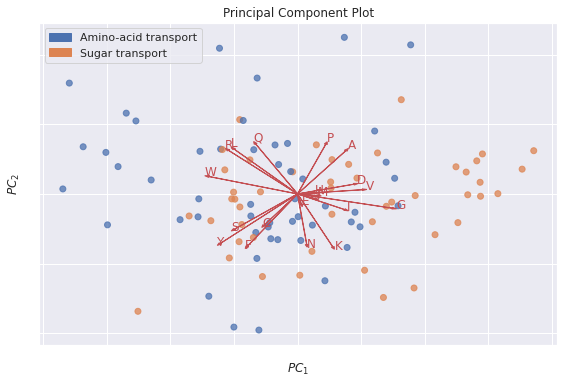

/home/ad/miniconda3/envs/subpred/lib/python3.9/site-packages/yellowbrick/features/pca.py:458: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


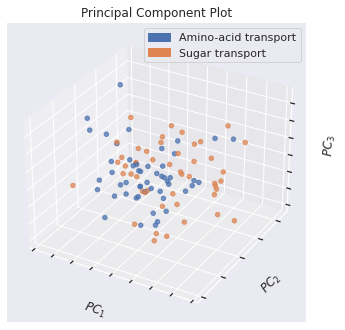

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [29]:
from yellowbrick.features import PCA as PCAPlot

le = LabelEncoder()
y = le.fit_transform(df_labels.labels.ravel())

pca_plot = PCAPlot(classes=le.classes_, scale=True, proj_features=True, features=df_aac.columns)
pca_plot.fit_transform(df_aac.to_numpy(), y)
pca_plot.show()

pca_plot = PCAPlot(classes=le.classes_, scale=True, features=df_aac.columns, projection=3)
pca_plot.fit_transform(df_aac.to_numpy(), y)
pca_plot.show()

### Performance Test

Mit einem einfachen Modell ohne PCA und nur mit SVC verbessert sich die test score um ca 0.07, nachdem outlier entfernt wurden.

In [30]:
single_substrate = ~df_annotations_outliers.keywords_transport.str.contains(";")
X = df_aac_outliers.loc[single_substrate].to_numpy()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_labels_outliers.loc[single_substrate].to_numpy().ravel())
nested_crossval(
    X, y, params={}, pipe=make_pipeline(StandardScaler(), SVC(class_weight="balanced")), scoring="f1_weighted"
)

,0,1,2,3,4,mean,std
test_score,0.825,0.692,0.725,0.863,0.760,0.773,0.071
train_score,0.944,0.933,0.944,0.922,0.956,0.940,0.013


In [31]:
X = df_aac.to_numpy()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_labels.to_numpy().ravel())
nested_crossval(
    X, y, params={}, pipe=make_pipeline(StandardScaler(), SVC(class_weight="balanced")), scoring="f1_weighted"
)

,0,1,2,3,4,mean,std
test_score,0.798,0.749,0.950,0.850,0.837,0.837,0.074
train_score,0.949,0.962,0.975,0.937,0.950,0.955,0.014


In [32]:
df_annotations[df_annotations.keywords_location == "Cell membrane;Membrane;Transmembrane"]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P76249,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,leuE yeaS b1798 JW1787,Leucine efflux protein,2.A.76.1.5,83333,MFAEYGVLNYWTYLVGAIFIVLVPGPNTLFVLKNSVSSGMKGGYLA...
